<a href="https://colab.research.google.com/github/Kwannn666/GAN_AI/blob/main/Q36134255_HW10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  打造自己的圖像生成Web App!

### 1. 安裝必要套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
# from google.colab import userdata

# hf_token = userdata.get("HuggingFace")
# login(token=hf_token)

在這邊根據 ChatGPT 的建議以及協助推荐並引入了支援的多個 scheduler 類別

In [ ]:
from diffusers import (StableDiffusionPipeline, UniPCMultistepScheduler, DDIMScheduler,
              DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler,
              EulerDiscreteScheduler)
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random
import openai
import os

OpenAI API 金鑰

In [ ]:
import os
from google.colab import userdata
from openai import OpenAI

# 讀取 OpenAI API 金鑰
api_key = userdata.get('OpenAI')
os.environ["OPENAI_API_KEY"] = api_key

# 建立 OpenAI 客戶端
client = OpenAI(api_key=api_key)

# 指定模型
model = "gpt-4o"

### 2. 指定並讀入模型

這邊是使用 https://huggingface.co/Lykon/dreamshaper-8 的
Lykon/dreamshaper-8 生圖模型

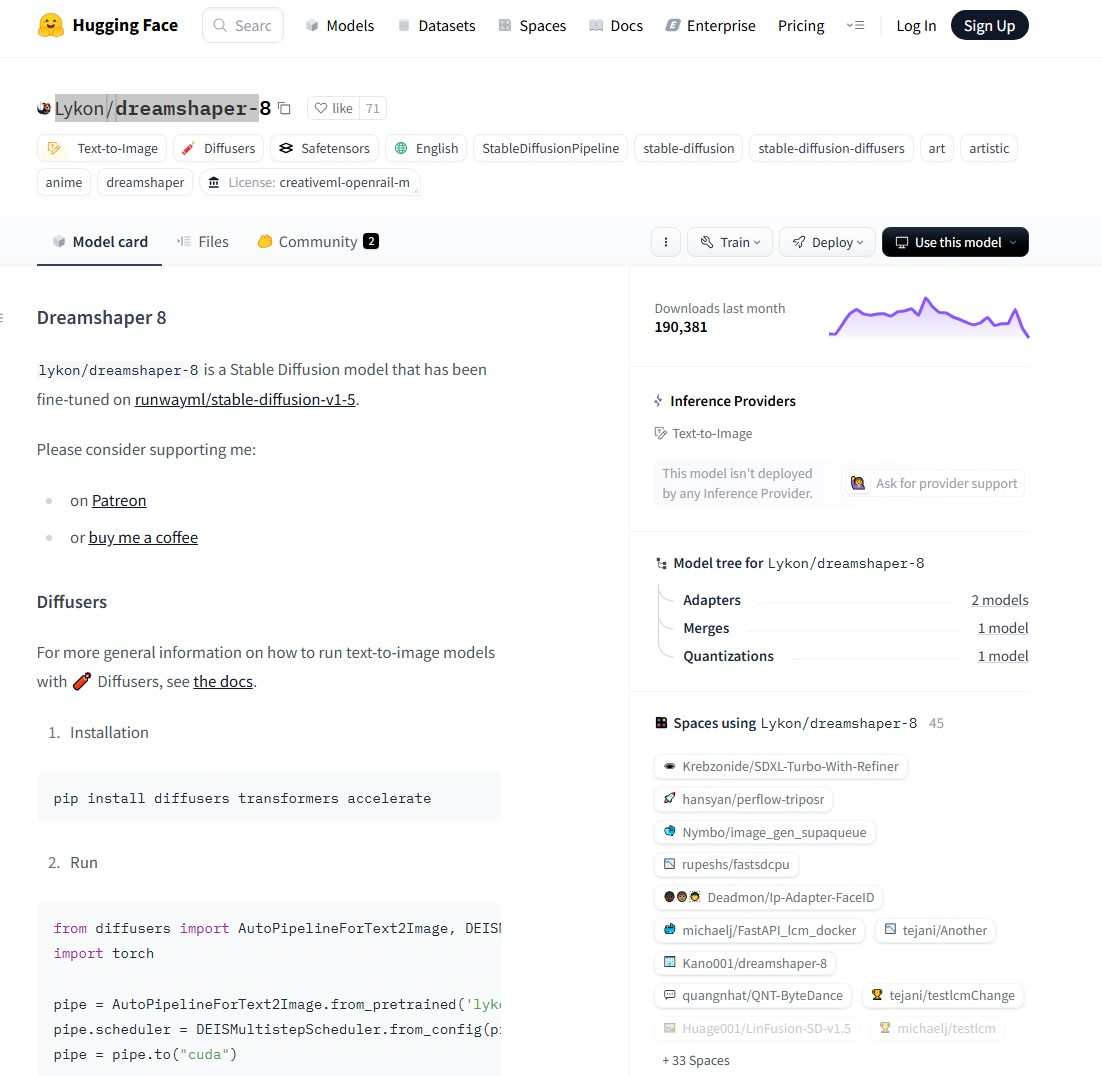

In [ ]:
model_name = "Lykon/dreamshaper-8"

如果產生錯誤的話可能要停用 `use_safetensors=True`。

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/796 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


在這裡建立一個映射字典，讓使用者能用簡單名稱選擇，並且根據 ChatGPT 的協助進一步進行程式碼的改進及優化

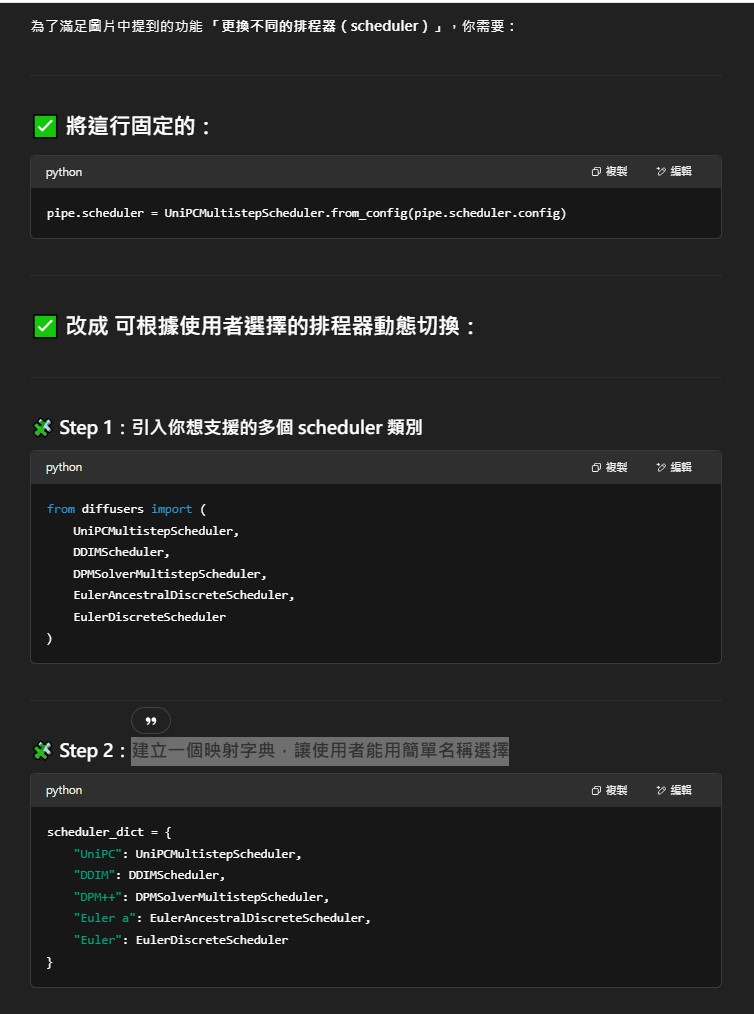

In [ ]:
scheduler_dict = {
    "UniPC": UniPCMultistepScheduler,
    "DDIM": DDIMScheduler,
    "DPM++": DPMSolverMultistepScheduler,
    "Euler a": EulerAncestralDiscreteScheduler,
    "Euler": EulerDiscreteScheduler
}


In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images,
                    scheduler_name):
    global pipe
    scheduler_class = scheduler_dict[scheduler_name]
    pipe.scheduler = scheduler_class.from_config(pipe.scheduler.config)

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    base_seed = int(custom_seed) if use_custom_seed else random.randint(0, 2**32 - 1)
    seeds = [base_seed + i for i in range(num_images)]

    final_prompt = prompt + ", " + enhance_text if use_enhance else prompt
    final_negative = negative_text if use_negative else None

    generators = [torch.Generator("cuda").manual_seed(seed) for seed in seeds]
    prompts = [final_prompt] * num_images
    negative_prompts = [final_negative] * num_images

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i],
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"


### 4. OpenAI 翻譯函數

使用 gpt-4o 模型來進行中文輸入的 prompts 翻譯成英文的 prompts 來讓模型更好進行輸入以及理解

In [ ]:
def translate_prompt_zh_to_en(prompt_zh):
    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "你是一位專業圖像生成提示詞優化助手，請將以下繁體中文翻譯成英文 prompt 並加以優化。"},
                {"role": "user", "content": prompt_zh}
            ]
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        return f"翻譯失敗：{str(e)}"

### 5. 打造 Gradio Web App

這邊新增了三個新功能

1. 可以選擇不同的 preset_prompts 來讓使用者可以選擇不同的生成風格

2. 使用者不需輸入英文的 prompts ，可以透過輸入中文的提示詞來達到想要生成的圖片

3. 使用者可以選擇不同的排程器來讓圖片達到最佳的生成效果

In [ ]:
preset_prompts = {
    "寫實風": (
        "masterpiece, ultra realistic, 8k, detailed lighting, photographic face, cinematic shadows",
        "blurry, deformed face, bad anatomy, disfigured, watermark, text"
    ),
    "動漫風": (
        "anime illustration, vibrant color, 1girl, dynamic pose, large eyes, finely drawn hair",
        "bad hands, extra limbs, cropped, lowres, worst quality"
    ),
    "奇幻風": (
        "fantasy scene, epic landscape, glowing particles, magic aura, heroic figure, mystical lighting",
        "overexposed, flat color, poor composition, distorted anatomy"
    )
}

def get_presets(style):
    return preset_prompts.get(style, ("", ""))

with gr.Blocks() as demo:
    gr.Markdown("""# SD1.5 dreamshaper 多功能圖像生成器""")
    with gr.Row():
        with gr.Column():
            zh_prompt = gr.Textbox(label="中文提示詞 (可留空)", lines=1)
            prompt = gr.Textbox(label="英文 Prompt (優先使用)", lines=2)
            translate_btn = gr.Button("🔁 中文翻譯並優化")

            style = gr.Dropdown(["寫實風", "動漫風", "奇幻風"], label="選擇風格", value="寫實風")
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容")
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt")
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, step=5, value=20, label="生成步數")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            scheduler_dropdown = gr.Dropdown(label="排程器選擇", choices=list(scheduler_dict.keys()), value="UniPC")
            generate_btn = gr.Button("開始生成")

        with gr.Column():
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain")
            seed_info = gr.Label(label="使用的 Random Seeds")

    style.change(fn=get_presets, inputs=style, outputs=[enhance_text, negative_text])
    translate_btn.click(fn=translate_prompt_zh_to_en, inputs=zh_prompt, outputs=prompt)
    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images,
                scheduler_dropdown],
        outputs=[gallery, seed_info]
    )

In [ ]:
# ✅ 啟動介面
demo.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://ac141a976cc028a356.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2146, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1664, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ac141a976cc028a356.gradio.live
